In [157]:

Ttot = 5   # total signal duration [s]
sigFile = './test_sound.wav'  # signal file
rirFile = './myRIR.wav'       # RIR file
rirDur = 0.5    # RIR duration [s]

Import signals

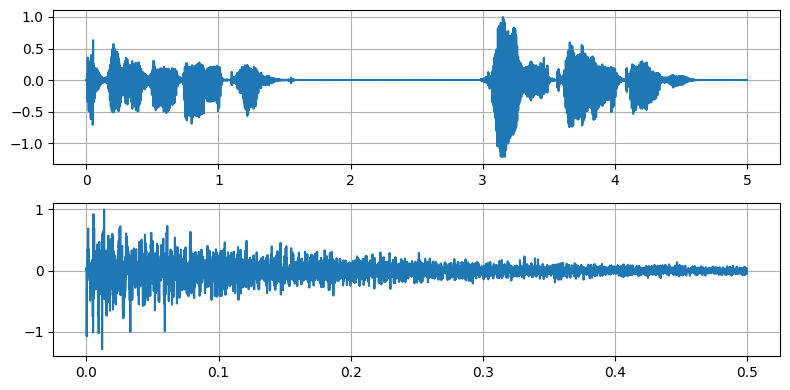

RIR length: 22050 samples.


In [158]:
import soundfile as sf
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')  # <-- for Jupyter: white figures 

# Read RIR file
h, fs = sf.read(rirFile)

# Read raw sound file
x, fsFile = sf.read(sigFile)
if fsFile != fs:
    print(f'Resampling `x` to {fs} samples/s.')
    x = sig.resample(x, axis=0, num=int(fs * Ttot))
    
if x.ndim == 2:
    # Truncate and make mono
    x = x[:int(fs * Ttot), 0]
elif x.ndim == 1:
    # Just truncate
    x = x[:int(fs * Ttot)]
x /= np.amax(x)
tSig = np.arange(len(x))/fs

if h.ndim == 2:
    # Truncate and make mono
    h = h[:int(fs * rirDur), 0]
elif h.ndim == 1:
    # Just truncate
    h = h[:int(fs * rirDur)]
tRir = np.arange(len(h))/fs
# h = np.zeros_like(h)
# h[0] = 1
# h[1] = -1
h /= np.amax(h)

print(f'RIR length: {len(h)} samples.')

OLA processing

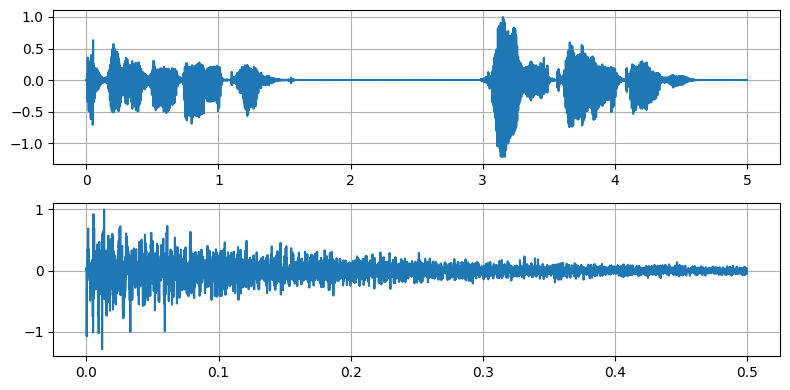

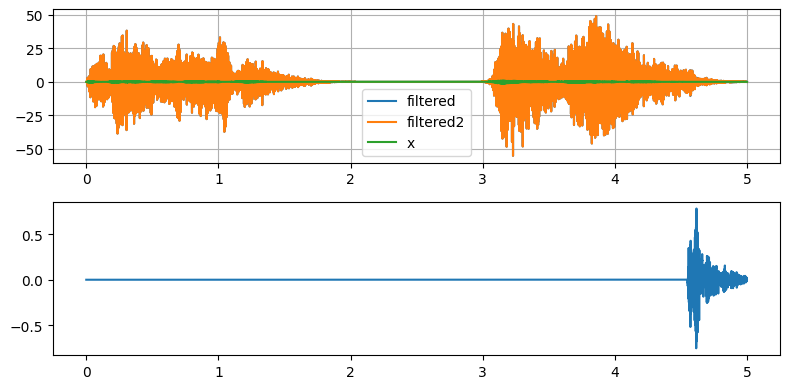

In [173]:
# OLA parameters

frameSize = 2**12   # processing frame size [samples]
ovlp = 0            # overlap between consecutive chunks [0 <= ovlp <= 1]
nNewSamplesPerChunk = int(frameSize * (1 - ovlp))


# Get frequency domain filter coefficients
totalLength = frameSize + len(h) - 1
hzp = np.concatenate((h, np.zeros(totalLength - len(h))))
w = np.fft.fft(hzp, totalLength) 

flagStop = False
n = 0
y = np.zeros_like(x)
while not flagStop:
    idxBegChunk = n*nNewSamplesPerChunk
    idxEndChunk = idxBegChunk + frameSize
    # Select current data chunk
    xcurr = x[idxBegChunk:idxEndChunk]

    # Zero-pad
    xcurrzp = np.concatenate((xcurr, np.zeros(totalLength - frameSize)))

    # Go to frequency domain
    Xcurr = np.fft.fft(xcurrzp, totalLength)

    # Apply filter
    Ycurr = Xcurr * w

    # Go back to time domain
    ycurr = np.fft.ifft(Ycurr, totalLength)
    ycurr = np.real(ycurr)
    
    # Overlap and add
    if idxBegChunk + totalLength > len(y):
        samplesToDiscard = idxBegChunk + totalLength - len(y)
        y[idxBegChunk:idxBegChunk + totalLength] += ycurr[:-samplesToDiscard]
        flagStop = True
    else:
        y[idxBegChunk:idxBegChunk + totalLength] += ycurr

    # Go to next chunk
    n += 1
    if n*nNewSamplesPerChunk + frameSize > len(x):
        flagStop = True

# Verification plot
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(211)
ax.plot(tSig, x)
ax.grid()
ax = fig.add_subplot(212)
ax.plot(tRir, h)
ax.grid()
plt.tight_layout()	
plt.show()


fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(tSig, y, label='filtered')
ax.plot(tSig, x, label='x')
plt.legend()
ax.grid()
plt.tight_layout()	
plt.show()

Text(0.5, 1.0, 'Difference')

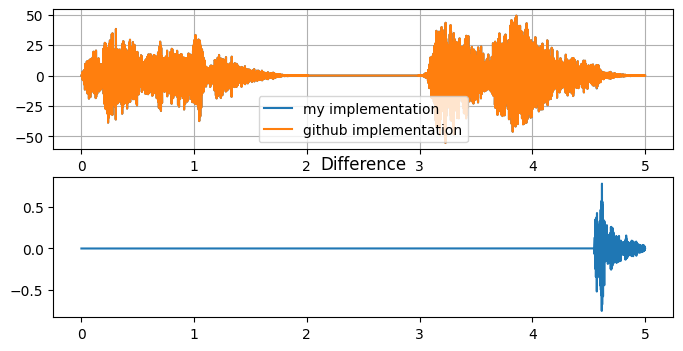

In [175]:
# Comparison with function from https://github.com/jthiem/overlapadd

def olafilt(b, x, zi=None):
    """
    Filter a one-dimensional array with an FIR filter
    Filter a data sequence, `x`, using a FIR filter given in `b`.
    Filtering uses the overlap-add method converting both `x` and `b`
    into frequency domain first.  The FFT size is determined as the
    next higher power of 2 of twice the length of `b`.
    Parameters
    ----------
    b : one-dimensional numpy array
        The impulse response of the filter
    x : one-dimensional numpy array
        Signal to be filtered
    zi : one-dimensional numpy array, optional
        Initial condition of the filter, but in reality just the
        runout of the previous computation.  If `zi` is None or not
        given, then zero initial state is assumed.
    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    """

    L_I = b.shape[0]
    # Find power of 2 larger that 2*L_I (from abarnert on Stackoverflow)
    L_F = 2<<(L_I-1).bit_length()
    L_S = L_F - L_I + 1
    L_sig = x.shape[0]
    offsets = range(0, L_sig, L_S)

    # handle complex or real input
    if np.iscomplexobj(b) or np.iscomplexobj(x):
        fft_func = np.fft.fft
        ifft_func = np.fft.ifft
        res = np.zeros(L_sig+L_F, dtype=np.complex128)
    else:
        fft_func = np.fft.rfft
        ifft_func = np.fft.irfft
        res = np.zeros(L_sig+L_F)

    FDir = fft_func(b, n=L_F)

    # overlap and add
    for n in offsets:
        res[n:n+L_F] += ifft_func(fft_func(x[n:n+L_S], n=L_F)*FDir)

    if zi is not None:
        res[:zi.shape[0]] = res[:zi.shape[0]] + zi
        return res[:L_sig], res[L_sig:]
    else:
        return res[:L_sig]

y2 = olafilt(h, x)


fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(211)
ax.plot(tSig, y, label='my implementation')
ax.plot(tSig, y2, label='github implementation')
plt.legend()
ax.grid()
ax = fig.add_subplot(212)
ax.plot(tSig, y - y2)
ax.set_title('Difference')

Listen to signals

In [161]:

import simpleaudio as sa
import copy

audio_array = copy.copy(x)
audio_array *= 32767 / max(abs(audio_array))
audio_array = audio_array.astype(np.int16)
po = sa.play_buffer(audio_array,1,2,fs)
po.wait_done()
audio_array = copy.copy(y)
audio_array *= 32767 / max(abs(audio_array))
audio_array = audio_array.astype(np.int16)
po = sa.play_buffer(audio_array,1,2,fs)
